In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Simulators import BanditSimulator, ConfoundingBanditSimulator
from Samplers import StandardThomspon, CausalThomspon
from Environment import Environment

In [5]:
# Total Regret after n pulls:
def regret(probabilities, choices):  
    w_opt = probabilities.max()
    return(w_opt - probabilities[choices.astype(int)]).cumsum()

def regret_causal(probabilities, choices):
    regret_arr = []
    last = 0
    for i in range(0, len(probabilities)):
        prob = probabilities[i]
        w_opt = prob.max()
        reg = w_opt - prob[choices[i]]
        regret_arr.append(reg + last)
        last = reg + last
    return np.array(regret_arr)

### Standard Sampler on Non-Confounding simulator

In [6]:
# Input bandit probabilities
True_bandit_probs = np.array([0.3, 0.60, 0.75])

# Simulate the bandits
bandits = BanditSimulator(True_bandit_probs)

# Select sampling algorithm
bandit_algo = StandardThomspon(bandits, Environment({}))

Plot expected value of regret. For this we repeat the experiment `n_trials` times and calculate the expected value of the regret at each pull. For large values of `n_pulls` and `n_trials`, this takes a couple minutes.

In [8]:
# Cumulative regret:
n_pulls = 1000 # number pulls for a trial
n_trials = 10 # number of trials/times we repeat the experiment to get E[regret]
expected_total_regret = np.zeros(n_pulls)
for i in range(n_trials):
    bandit_algo.initialize() # reset these variables to their blank states
    bandit_algo.sample_bandits(n_pulls)
    regret_this_trial = regret(True_bandit_probs, np.array(bandit_algo.choices))
    expected_total_regret += regret_this_trial
                                                

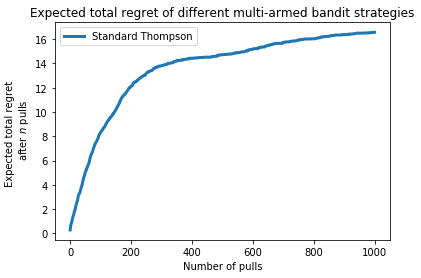

In [9]:
plt.plot(expected_total_regret/n_trials, lw =3,
          label = "Standard Thompson")

plt.title("Expected total regret of different multi-armed bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Expected total regret \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()

### Standard and Causal Sampler on Confounding Simulator

In [10]:
# Setup the bandit sampler
causal_bandit_probs = np.array([
    np.array([
        np.array([.1, .5]),
        np.array([.4, .2])
    ]),
    np.array([
        np.array([.5, .1]),
        np.array([.2, .4])
    ])
])
confoundingBandits = ConfoundingBanditSimulator(causal_bandit_probs)

# Setup the environment
environment_probs = {
    'drunk': .5,
    'blinking': .5
}
environment = Environment(environment_probs)

In [11]:
# Select sampling algorithm
# bandit_algo = StandardThomspon(bandits, environment)
standard_sampler = StandardThomspon(confoundingBandits, environment)
causal_sampler = CausalThomspon(confoundingBandits, environment)

# Cumulative regret:
n_pulls = 300 # number pulls for a trial
n_trials = 5 # number of trials/times we repeat the experiment to get E[regret]
exp_tot_standard_regret = np.zeros(n_pulls)
exp_tot_causal_regret = np.zeros(n_pulls)

for i in range(n_trials):
    standard_sampler.initialize()
    standard_sampler.sample_bandits(n_pulls)
    
    causal_sampler.initialize()
    causal_sampler.sample_bandits(n_pulls)
    
    # Calculate Causal Regret
    standard_trial_probs = []
    for env in standard_sampler.observed_envs:
        drunk = int(env['drunk'])
        blinking = int(env['blinking'])
        probs = causal_bandit_probs[drunk][blinking]
        causal_trial_probs.append(probs)
        
    standard_trial_regret = regret_causal(True_bandit_probs, standard_sampler.choices)
    exp_tot_standard_regret += standard_trial_regret
    
    
    # Calculate Causal Regret
    causal_trial_probs = []
    for env in causal_sampler.observed_envs:
        drunk = int(env['drunk'])
        blinking = int(env['blinking'])
        probs = causal_bandit_probs[drunk][blinking]
        causal_trial_probs.append(probs)
    
    causal_trial_regret = regret_causal(causal_trial_probs, causal_sampler.choices)
    exp_tot_causal_regret += causal_trial_regret

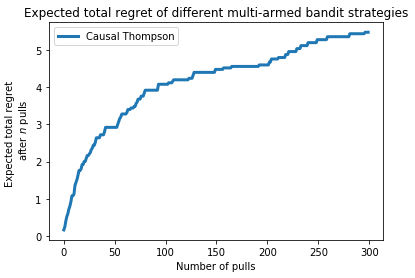

In [12]:
plt.plot(expected_total_regret/n_trials, lw =3,
          label = "Causal Thompson")

plt.title("Expected total regret of different multi-armed bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Expected total regret \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()